In [ ]:
# pip install esential libraries
!pip install torchtext==0.13.1 -q
!pip install pytorch-lightning==1.9.4 -q

In [ ]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split

In [ ]:
torch.cuda.empty_cache()

### Data Loading

In [ ]:
file_path = "/content/drive/MyDrive/semeval-dataset/"
train_fname = "eng_train.csv"
dev_fname = "eng_a_dev.csv"
# test_fname = "eng_b_test.csv  , not yet available

In [ ]:
if os.path.exists(file_path):
    train_df = pd.read_csv(file_path + train_fname)
    dev_df = pd.read_csv(file_path + dev_fname)
    # test_df = pd.read_csv(file_path + test_fname)
    print("All Data loaded successfully!")
else:
    print(f"Error: File not found at {file_path + '...'}")

All Data loaded successfully!


In [ ]:
train_df.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


In [ ]:
dev_df.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_dev_track_a_00001,"My mouth fell open `` No, no, no... I..",NaN,NaN,NaN,NaN,NaN
1,eng_dev_track_a_00002,You can barely make out your daughter's pale f...,NaN,NaN,NaN,NaN,NaN
2,eng_dev_track_a_00003,But after blinking my eyes for a few times lep...,NaN,NaN,NaN,NaN,NaN
3,eng_dev_track_a_00004,Slowly rising to my feet I came to the conclus...,NaN,NaN,NaN,NaN,NaN
4,eng_dev_track_a_00005,I noticed this months after moving in and doin...,NaN,NaN,NaN,NaN,NaN


Observation:

* Just 5 labels, `disgust` class is not included in this dataset

### Simple EDA

In [ ]:
train_df.text.values[1]

"Well she's not gon na last the whole song like that, so since I'm behind her and the audience can't see below my torso pretty much, I use my hand to push down on the lid and support her weight."

In [ ]:
labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [ ]:
# distribution of the labels in the training set
for label in labels:
    print(train_df[label].value_counts(normalize= True))

Anger
0    0.879697
1    0.120303
Name: proportion, dtype: float64
Fear
1    0.582009
0    0.417991
Name: proportion, dtype: float64
Joy
0    0.756503
1    0.243497
Name: proportion, dtype: float64
Sadness
0    0.682803
1    0.317197
Name: proportion, dtype: float64
Surprise
0    0.696893
1    0.303107
Name: proportion, dtype: float64


In [ ]:
train_df.shape

(2768, 7)

In [ ]:
# distribution of the labels in the validation set
for label in labels:
    print(dev_df[label].value_counts(normalize= True))

Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)


Okay Okay, the validation labels are empty/ NAN :( . Anyways, we can create a temporary validation set from the training data and use the dev data as test set for submission.

In [ ]:
dev_df.shape

(116, 7)

### Text Preprocessing

In [ ]:
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
BATCH_SIZE = 32

tokenizer = get_tokenizer('basic_english')


In [ ]:
#special tokens
unk_token = '<unk>'
pad_token = '<pad>'

In [ ]:
# applying the tokenizer func to all the rows of data
%%time
text_tokens = train_df.text.map(tokenizer)

CPU times: user 47.5 ms, sys: 10.7 ms, total: 58.2 ms
Wall time: 78.4 ms


In [ ]:
vocab = build_vocab_from_iterator(
    text_tokens,
    specials=[unk_token, pad_token],
    max_tokens=VOCAB_SIZE
)

In [ ]:
# check
print("unknown token index:",vocab[unk_token])
print("pad token index:",vocab[pad_token])

unknown token index: 0
pad token index: 1


In [ ]:
vocab.set_default_index(vocab[unk_token])

In [ ]:
#check for unseen words
vocab['semeval']

0

In [ ]:
vocab['tiamiyu']

0

<Axes: ylabel='Frequency'>

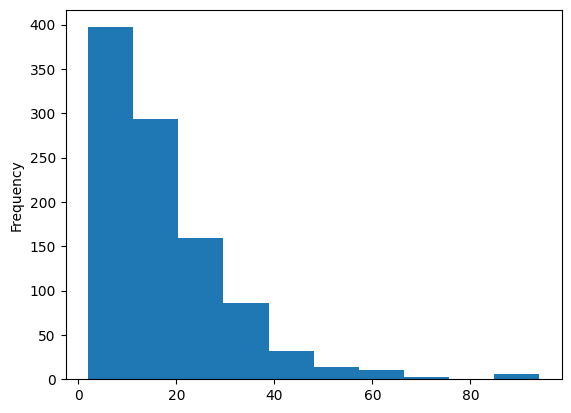

In [ ]:
train_df.text.sample(1000).map(tokenizer).map(len).plot.hist()

In [ ]:
MAX_LENGTH = 60

In [ ]:
def pad_tokens(tokens):
  if len(tokens) >= MAX_LENGTH:
    return tokens[:MAX_LENGTH]
  else:
    return tokens + [pad_token] * (MAX_LENGTH - len(tokens))

In [ ]:
# check check
train_df.text.values[0]


'But not very happy.'

In [ ]:
pad_tokens(tokenizer(train_df.text.values[0])) [:10]

['but',
 'not',
 'very',
 'happy',
 '.',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, df, is_dev= False):
    self.df = df
    self.is_dev = is_dev

  def __getitem__(self, index):
    comment_text = self.df.text.values[index]
    comment_tokens = tokenizer(comment_text)
    comment_tokens_padded = pad_tokens(comment_tokens)
    input = torch.tensor(vocab.lookup_indices(comment_tokens_padded))
    if self.is_dev:
      target  = torch.tensor([0,0,0,0,0]).float()
    else:
      target = torch.tensor(self.df[labels].values[index]).float()
    return input, target

  def __len__(self):
    return len(self.df)

In [ ]:
train_ds = EmotionDataset(train_df)

In [ ]:
train_ds[0]

(tensor([ 19,  39,  90, 375,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1]),
 tensor([0., 0., 1., 1., 0.]))

In [ ]:
frac = 0.25

In [ ]:
# train_ds, val_ds = random_split(raw_ds, [1-frac, frac])

train_size = int(len(train_ds) * (1 - frac)) # Calculate the length of the training set
val_size = len(train_ds) - train_size # Calculate the length of the validation set
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) # Split the dataset based on calculated lengths

In [ ]:
len(train_ds), len(val_ds)

(2076, 692)

In [ ]:
dev_ds = EmotionDataset(dev_df, is_dev=True)

In [ ]:
dev_ds[0]

(tensor([  3, 120, 171, 196,  80,  85,   5,  85,   5,  85,   2,   2,   2,   4,
           2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1]),
 tensor([0., 0., 0., 0., 0.]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
dev_dl = DataLoader(dev_ds)

In [ ]:
emb_layer = nn.Embedding(num_embeddings=VOCAB_SIZE,embedding_dim=256,padding_idx=1)

In [ ]:
class EmotionDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, 256, 1)
        self.lstm = nn.LSTM(256, 128, 1, batch_first=True)
        self.linear = nn.Linear(128, 5)
        self.learning_rate = 0.001

    def forward(self, x):
        out = self.emb(x)
        out, hn = self.lstm(out)
        out = F.relu(out[:,-1,:])
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return loss.item()

    def validation_epoch_end(self, validation_step_outputs):
        loss = np.mean(validation_step_outputs)
        print("Epoch #{}; Loss: {:4f} ".format(self.current_epoch, loss))

    def predict_step(self, batch, batch_idx):
      inputs, _ = batch
      outputs = self(inputs)
      probs = torch.sigmoid(outputs)
      predictions = (probs > 0.45).float()
      return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
base_model = EmotionDetectionModel()

In [ ]:
trainer = pl.Trainer(max_epochs=100, accelerator='gpu', auto_lr_find = True) # auto_lr_find is deprecated in the latest version of pl

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(base_model, train_dl) # if you are using latest version of pl, dont run this code

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.15848931924611143
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c2e2f32a-605d-4ae6-83a6-8f74d43e56af.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_c2e2f32a-605d-4ae6-83a6-8f74d43e56af.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7a0c06164580>}

In [ ]:
trainer.fit(base_model, train_dl, val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | lstm   | LSTM      | 197 K 
2 | linear | Linear    | 645   
-------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.841     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.699030 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.581176 


Validation: 0it [00:00, ?it/s]

Epoch #1; Loss: 0.586406 


Validation: 0it [00:00, ?it/s]

Epoch #2; Loss: 0.595988 


Validation: 0it [00:00, ?it/s]

Epoch #3; Loss: 0.595787 


Validation: 0it [00:00, ?it/s]

Epoch #4; Loss: 0.595907 


Validation: 0it [00:00, ?it/s]

Epoch #5; Loss: 0.588159 


Validation: 0it [00:00, ?it/s]

Epoch #6; Loss: 0.583240 


Validation: 0it [00:00, ?it/s]

Epoch #7; Loss: 0.588370 


Validation: 0it [00:00, ?it/s]

Epoch #8; Loss: 0.599723 


Validation: 0it [00:00, ?it/s]

Epoch #9; Loss: 0.613057 


Validation: 0it [00:00, ?it/s]

Epoch #10; Loss: 0.584322 


Validation: 0it [00:00, ?it/s]

Epoch #11; Loss: 0.583791 


Validation: 0it [00:00, ?it/s]

Epoch #12; Loss: 0.595136 


Validation: 0it [00:00, ?it/s]

Epoch #13; Loss: 0.585371 


Validation: 0it [00:00, ?it/s]

Epoch #14; Loss: 0.594042 


Validation: 0it [00:00, ?it/s]

Epoch #15; Loss: 0.595384 


Validation: 0it [00:00, ?it/s]

Epoch #16; Loss: 0.592156 


Validation: 0it [00:00, ?it/s]

Epoch #17; Loss: 0.590069 


Validation: 0it [00:00, ?it/s]

Epoch #18; Loss: 0.600310 


Validation: 0it [00:00, ?it/s]

Epoch #19; Loss: 0.588029 


Validation: 0it [00:00, ?it/s]

Epoch #20; Loss: 0.587966 


Validation: 0it [00:00, ?it/s]

Epoch #21; Loss: 0.585864 


Validation: 0it [00:00, ?it/s]

Epoch #22; Loss: 0.582428 


Validation: 0it [00:00, ?it/s]

Epoch #23; Loss: 0.596539 


Validation: 0it [00:00, ?it/s]

Epoch #24; Loss: 0.591604 


Validation: 0it [00:00, ?it/s]

Epoch #25; Loss: 0.592058 


Validation: 0it [00:00, ?it/s]

Epoch #26; Loss: 0.584657 


Validation: 0it [00:00, ?it/s]

Epoch #27; Loss: 0.588828 


Validation: 0it [00:00, ?it/s]

Epoch #28; Loss: 0.585267 


Validation: 0it [00:00, ?it/s]

Epoch #29; Loss: 0.589082 


Validation: 0it [00:00, ?it/s]

Epoch #30; Loss: 0.602885 


Validation: 0it [00:00, ?it/s]

Epoch #31; Loss: 0.611710 


Validation: 0it [00:00, ?it/s]

Epoch #32; Loss: 0.590082 


Validation: 0it [00:00, ?it/s]

Epoch #33; Loss: 0.585894 


Validation: 0it [00:00, ?it/s]

Epoch #34; Loss: 0.614526 


Validation: 0it [00:00, ?it/s]

Epoch #35; Loss: 0.594352 


Validation: 0it [00:00, ?it/s]

Epoch #36; Loss: 0.585048 


Validation: 0it [00:00, ?it/s]

Epoch #37; Loss: 0.602669 


Validation: 0it [00:00, ?it/s]

Epoch #38; Loss: 0.604916 


Validation: 0it [00:00, ?it/s]

Epoch #39; Loss: 0.595834 


Validation: 0it [00:00, ?it/s]

Epoch #40; Loss: 0.587277 


Validation: 0it [00:00, ?it/s]

Epoch #41; Loss: 0.586295 


Validation: 0it [00:00, ?it/s]

Epoch #42; Loss: 0.598387 


Validation: 0it [00:00, ?it/s]

Epoch #43; Loss: 0.589351 


Validation: 0it [00:00, ?it/s]

Epoch #44; Loss: 0.588748 


Validation: 0it [00:00, ?it/s]

Epoch #45; Loss: 0.588857 


Validation: 0it [00:00, ?it/s]

Epoch #46; Loss: 0.586704 


Validation: 0it [00:00, ?it/s]

Epoch #47; Loss: 0.588194 


Validation: 0it [00:00, ?it/s]

Epoch #48; Loss: 0.599424 


Validation: 0it [00:00, ?it/s]

Epoch #49; Loss: 0.594431 


Validation: 0it [00:00, ?it/s]

Epoch #50; Loss: 0.604303 


Validation: 0it [00:00, ?it/s]

Epoch #51; Loss: 0.594687 


Validation: 0it [00:00, ?it/s]

Epoch #52; Loss: 0.591768 


Validation: 0it [00:00, ?it/s]

Epoch #53; Loss: 0.588955 


Validation: 0it [00:00, ?it/s]

Epoch #54; Loss: 0.607729 


Validation: 0it [00:00, ?it/s]

Epoch #55; Loss: 0.591137 


Validation: 0it [00:00, ?it/s]

Epoch #56; Loss: 0.587446 


Validation: 0it [00:00, ?it/s]

Epoch #57; Loss: 0.592197 


Validation: 0it [00:00, ?it/s]

Epoch #58; Loss: 0.602544 


Validation: 0it [00:00, ?it/s]

Epoch #59; Loss: 0.595209 


Validation: 0it [00:00, ?it/s]

Epoch #60; Loss: 0.599134 


Validation: 0it [00:00, ?it/s]

Epoch #61; Loss: 0.593323 


Validation: 0it [00:00, ?it/s]

Epoch #62; Loss: 0.601674 


Validation: 0it [00:00, ?it/s]

Epoch #63; Loss: 0.596553 


Validation: 0it [00:00, ?it/s]

Epoch #64; Loss: 0.596924 


Validation: 0it [00:00, ?it/s]

Epoch #65; Loss: 0.593696 


Validation: 0it [00:00, ?it/s]

Epoch #66; Loss: 0.596573 


Validation: 0it [00:00, ?it/s]

Epoch #67; Loss: 0.589295 


Validation: 0it [00:00, ?it/s]

Epoch #68; Loss: 0.592687 


Validation: 0it [00:00, ?it/s]

Epoch #69; Loss: 0.600637 


Validation: 0it [00:00, ?it/s]

Epoch #70; Loss: 0.588996 


Validation: 0it [00:00, ?it/s]

Epoch #71; Loss: 0.617229 


Validation: 0it [00:00, ?it/s]

Epoch #72; Loss: 0.596359 


Validation: 0it [00:00, ?it/s]

Epoch #73; Loss: 0.597712 


Validation: 0it [00:00, ?it/s]

Epoch #74; Loss: 0.593309 


Validation: 0it [00:00, ?it/s]

Epoch #75; Loss: 0.603873 


Validation: 0it [00:00, ?it/s]

Epoch #76; Loss: 0.593609 


Validation: 0it [00:00, ?it/s]

Epoch #77; Loss: 0.598241 


Validation: 0it [00:00, ?it/s]

Epoch #78; Loss: 0.595800 


Validation: 0it [00:00, ?it/s]

Epoch #79; Loss: 0.595097 


Validation: 0it [00:00, ?it/s]

Epoch #80; Loss: 0.592243 


Validation: 0it [00:00, ?it/s]

Epoch #81; Loss: 0.591442 


Validation: 0it [00:00, ?it/s]

Epoch #82; Loss: 0.607178 


Validation: 0it [00:00, ?it/s]

Epoch #83; Loss: 0.590916 


Validation: 0it [00:00, ?it/s]

Epoch #84; Loss: 0.590929 


Validation: 0it [00:00, ?it/s]

Epoch #85; Loss: 0.595056 


Validation: 0it [00:00, ?it/s]

Epoch #86; Loss: 0.608813 


Validation: 0it [00:00, ?it/s]

Epoch #87; Loss: 0.605243 


Validation: 0it [00:00, ?it/s]

Epoch #88; Loss: 0.594515 


Validation: 0it [00:00, ?it/s]

Epoch #89; Loss: 0.601680 


Validation: 0it [00:00, ?it/s]

Epoch #90; Loss: 0.614996 


Validation: 0it [00:00, ?it/s]

Epoch #91; Loss: 0.616190 


Validation: 0it [00:00, ?it/s]

Epoch #92; Loss: 0.598353 


Validation: 0it [00:00, ?it/s]

Epoch #93; Loss: 0.604180 


Validation: 0it [00:00, ?it/s]

Epoch #94; Loss: 0.597407 


Validation: 0it [00:00, ?it/s]

Epoch #95; Loss: 0.599457 


Validation: 0it [00:00, ?it/s]

Epoch #96; Loss: 0.611082 


Validation: 0it [00:00, ?it/s]

Epoch #97; Loss: 0.594146 


Validation: 0it [00:00, ?it/s]

Epoch #98; Loss: 0.597847 


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch #99; Loss: 0.598717 


In [ ]:
dev_preds = trainer.predict(base_model, dev_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 65it [00:00, ?it/s]

In [ ]:
dev_preds[:-10]

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0

In [ ]:
dev_preds = torch.cat(dev_preds)